
# Calculate Stats for Step Current for Different Sets of Parameters 

In [1]:
import os
import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir('../')

In [2]:
from scipy.signal import argrelmin, argrelmax

In [3]:
from dap import DAPcython
from dap.utils import obs_params, load_current
from tqdm import tqdm
from scipy.spatial import distance

### Set Parameters

In [4]:
dt = 1e-2
params, labels = obs_params(reduced_model=False)
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'

### load the file

In [5]:
# directory = './parameters/'
# dir = glob.glob(directory + '*')

# fname_start = dir[0].find('dap_')
# fname_stop = dir[0].find('n_')
# fname = dir[0][fname_start:fname_stop] + '.csv'

# df_param = pd.read_csv(fname)

In [6]:
df_param = pd.read_csv('dap_models_4_param_1x20.csv')

### calculate DAP

In [7]:
# load the input data
Ir, vr, tr, t_onr, t_offr, dtr = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
Is, vs, ts, t_ons, t_offs, dts = load_current(data_dir, protocol='IV', ramp_amp=1)

# define a model
dap = DAPcython(-75, params)

In [8]:
# run models on original parameters
U_step = dap.simulate(dts, ts, Is)
U_ramp = dap.simulate(dtr, tr, Ir)

### calculate the similarities

In [9]:
d_step = distance.euclidean(vs, U_step)
d_step

2666.233728007844

In [10]:
d_ramp = distance.euclidean(vr, U_ramp)
d_ramp

494.86315828621616

In [11]:
d_step+d_ramp

3161.0968862940604

### run for all cells and save into the the DF

In [12]:
df_paramT = df_param.transpose()
df_paramT.head()

,0,1,2,3
Unnamed: 0,gbar_nap,gbar_leak,gbar_nat,gbar_kdr
1x14,17.1737,1.07467,131.423,3.41051
1x35,17.0972,1.03987,117.684,3.73748
1x9,19.0074,0.991425,95.3657,2.97607
1x19,16.3705,1.0285,141.775,3.43003


In [13]:
df_paramT.drop('Unnamed: 0', inplace=True)
df_paramT.head()

,0,1,2,3
1x14,17.1737,1.07467,131.423,3.41051
1x35,17.0972,1.03987,117.684,3.73748
1x9,19.0074,0.991425,95.3657,2.97607
1x19,16.3705,1.0285,141.775,3.43003
1x24,15.1533,1.10018,163.721,3.05554


In [14]:
daps = []
U_steps = []
U_ramps = []

for i, j in tqdm(df_paramT.iterrows()):
    # get parameters
    par_temp = j.values

    # define a model
    daps.append(DAPcython(-75, j))

    # run model
    U_steps.append(dap.simulate(dts, ts, Is))
    U_ramps.append(dap.simulate(dtr, tr, Ir))

34it [01:08,  1.99s/it]


## Specify the Features Function 

In [15]:
def find_spikes(v):
    # look for non-resting potential values
    ind = np.where(v < -10)
    v[ind] = -10
    ind = np.where(np.diff(v) < 0)
    v[ind] = -10

    # look for all slope changes
    v = (np.diff(v) > 0).astype(int)

    # get all change of slopes indices
    v_ind = np.where(np.diff(np.sign(v)))[0]
    
    # return last positive change of slope 
    return v_ind[1::2]


In [16]:
def calc_features_step(U, t, dt, t_on, t_off):
    v = U.copy()
    N = v.shape[0]

    # resting potential
    rest_pot = np.mean(v[t<t_on])
    rest_pot_std = np.std(v[int(.9*t_on/dt):int(t_on/dt)])  
 
    ind = find_spikes(v)

    spike_times = np.array(t)[ind]
    spike_times_stim = spike_times[(spike_times > t_on)  & (spike_times < t_off)]
    ind_stim1 = ind[(spike_times > t_on) & (spike_times < t_off)]
    ind_stim = ind_stim1.astype(int)

    firing_rate = 1e3*np.absolute(spike_times_stim.shape[0]/(t_off-t_on))
    time_1st_spike = spike_times_stim[spike_times_stim>t_on][0]

    ISI = np.diff(spike_times_stim).astype(float)

    
    sum_stats_vec = np.array([
                rest_pot,
                rest_pot_std,
                len(spike_times_stim),
                spike_times_stim,
                firing_rate,
                ISI.mean(),
                ISI.std()
                ])


    return sum_stats_vec

In [17]:
def flatten(U):
    v = U.copy()
    ind = np.where(v < -10)
    v[ind] = -10
    ind = np.where(np.diff(v) < 0)
    v[ind] = -10
    
    return v

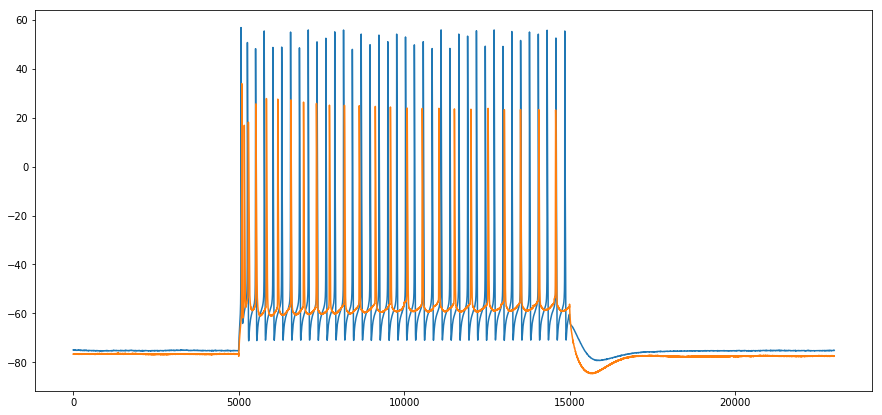

In [18]:
plt.figure(figsize=(15,7))
plt.plot(U_steps[0])
plt.plot(vs);

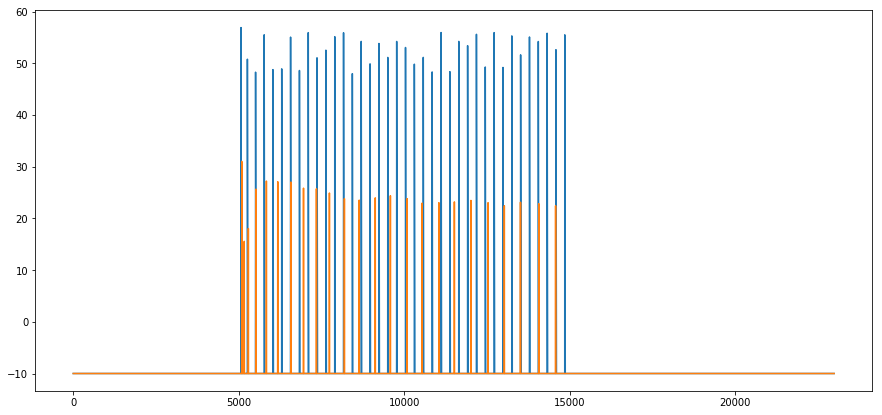

In [19]:
plt.figure(figsize=(15,7))
plt.plot(flatten(U_steps[0]))
plt.plot(flatten(vs));

In [20]:
x0 = calc_features_step(U_steps[0].transpose()[0], ts, dts, t_ons, t_offs)
x0

array([-75.2037517643215, 0.0321019319432001, 49,
       array([253.45, 263.1 , 275.45, 288.5 , 301.65, 314.95, 328.35, 341.75,
       355.1 , 355.2 , 368.3 , 381.7 , 395.1 , 395.2 , 408.4 , 408.5 ,
       421.7 , 435.1 , 435.2 , 448.45, 461.9 , 475.25, 488.7 , 502.05,
       515.4 , 528.9 , 542.3 , 555.8 , 555.9 , 569.1 , 582.55, 595.9 ,
       609.25, 609.35, 622.6 , 636.  , 636.1 , 649.35, 662.7 , 662.8 ,
       676.  , 689.4 , 702.75, 702.85, 716.1 , 716.2 , 729.4 , 742.75,
       742.85]),
       98.0, 10.195833333333333, 5.531687443468055], dtype=object)

In [21]:
x_orig = calc_features_step(vs.transpose(), ts, dts, t_ons, t_offs)
x_orig

array([-76.63358125, 0.06351057982730121, 24,
       array([254.6 , 258.4 , 264.6 , 275.95, 291.85, 309.  , 328.9 , 347.95,
       367.45, 387.1 , 409.75, 432.15, 456.4 , 479.25, 504.55, 527.35,
       552.55, 575.95, 600.95, 626.85, 651.45, 675.85, 703.5 , 728.9 ]),
       48.0, 20.62173913043478, 6.066798921122928], dtype=object)

### Vizualize found spikes

In [22]:
t = find_spikes(vs)
x = np.zeros_like(t)

In [23]:
len(x)

24

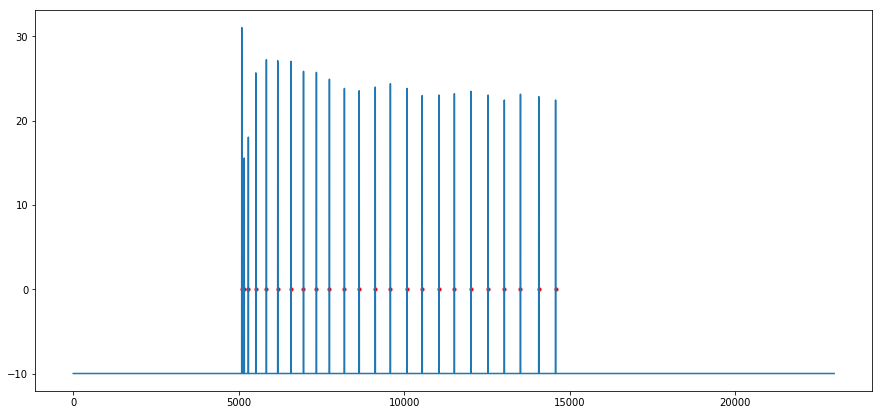

In [24]:
plt.figure(figsize=(15,7))
plt.scatter(t, x, c='r', s=10);
plt.plot(vs);

In [25]:
t_step = find_spikes(U_step.transpose()[0])
x_step = np.zeros_like(t_step)

In [26]:
len(x_step)

48

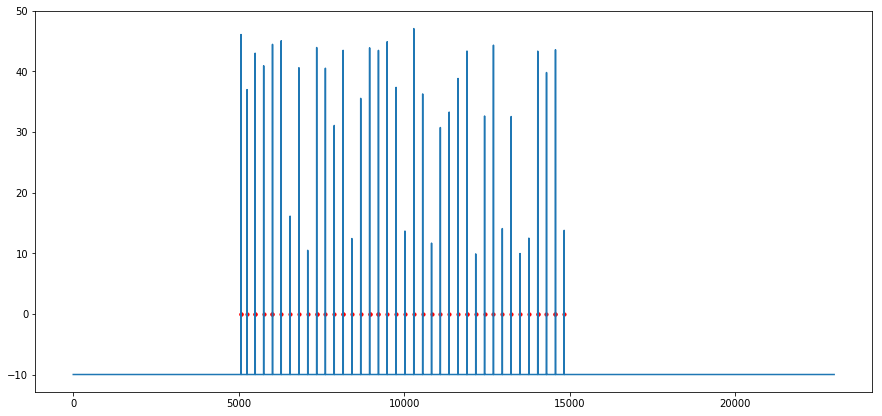

In [27]:
plt.figure(figsize=(15,7))
plt.scatter(t_step, x_step, c='r', s=10);
plt.plot(U_step);

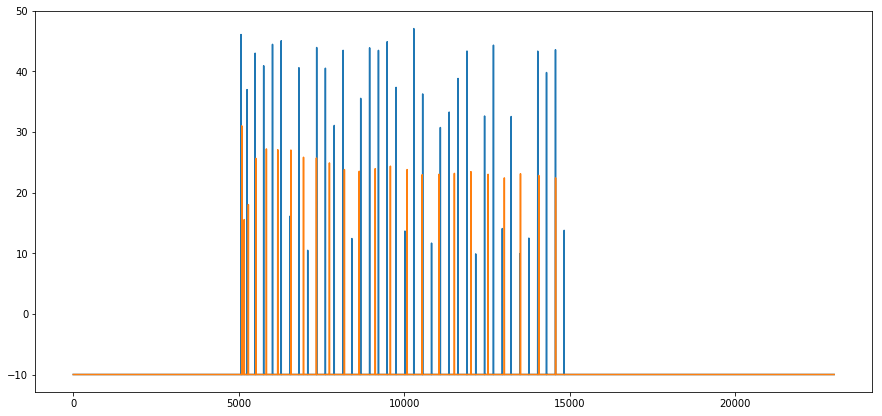

In [28]:
plt.figure(figsize=(15,7))
plt.plot(U_step);
plt.plot(vs);